In [1]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_TL_ERA5_to_CERRA_to_obs.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
train_dates_range = config['train_dates_range']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']
experiment = config['experiment']
run = 0

In [2]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')

In [3]:
X_train,Y_train,X_valid,Y_valid = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,train_dates_range,train_locations,val_arg=True)
X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,train_locations)
print('Training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape)
print('Validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)
print('Testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

Training inputs shape: (4620, 24) training targets shape: (4620, 5)
Validation inputs shape: (1440, 24) validation targets shape: (1440, 5)
Testing inputs shape: (955, 24) testing targets shape: (955, 5)


In [4]:
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
#df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

In [9]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,Obs=None,date=None,title=None,xlabel=None,ylabel=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    if Obs is not None:
        axs.plot(Obs,obs_levels, '--r', linewidth=2, markerfacecolor='r',label='Obs')

    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(f'{OUTPUT_DIR}/{fSTR}', "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    #p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
    #p95_profile = np.percentile(ensemble_predictions, 90, axis=0)

    # Plot median
    axs.plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    #axs.fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-31T11:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00


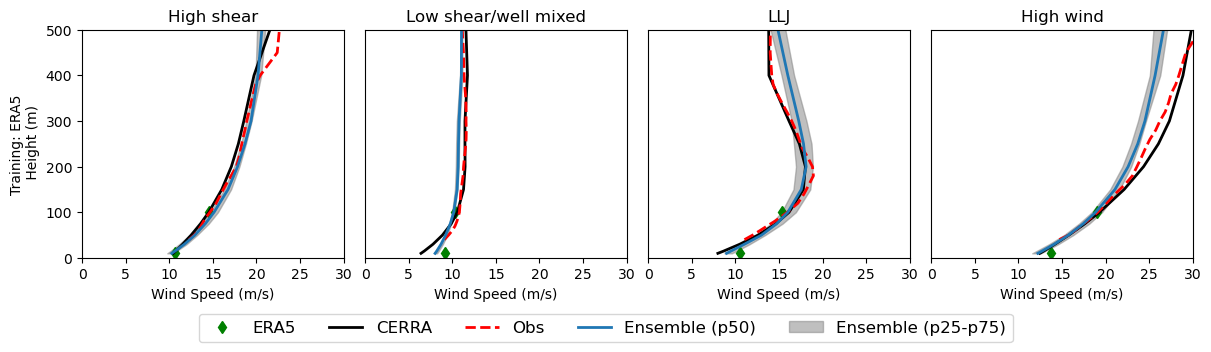

In [10]:
# best profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][0])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

0 High shear 2017-06-06T10:00:00
0 Low shear/well mixed 2017-11-20T13:00:00
0 LLJ 2017-03-30T02:00:00
0 High wind 2018-01-05T04:00:00


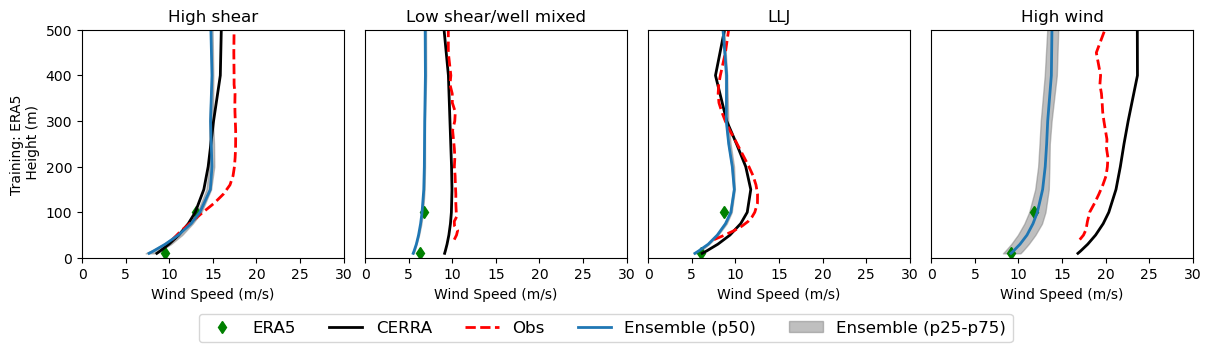

In [11]:
# worst profiles
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_test = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Obs = df_Obs[profile_dates[profile][1]:profile_dates[profile][1]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)